In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
TAG='sentiment'

### Result Analysis for each model

In [5]:
MODEL_NAME = 'bert'

bert_train_df = pd.read_csv('data/'+TAG+'_bert_prediction_train.csv', sep='\t')
bert_train_df.columns = ['news_id','sentence', MODEL_NAME+'_class_0', MODEL_NAME+'_class_1',
                         MODEL_NAME+'_pred', MODEL_NAME+'_answer']

bert_test_df = pd.read_csv('data/'+TAG+'_bert_prediction_test.csv', sep='\t')
bert_test_df.columns = ['news_id','sentence', MODEL_NAME+'_class_0', MODEL_NAME+'_class_1',
                        MODEL_NAME+'_pred',MODEL_NAME+'_answer']

print(bert_train_df.shape, bert_test_df.shape)

(15394, 6)


In [5]:
MODEL_NAME = 'cnn'

cnn_train_df = pd.read_csv('data/'+TAG+'_cnn_prediction_train.csv', sep='\t')
cnn_train_df.columns = ['news_id','sentence', MODEL_NAME+'_class_0', MODEL_NAME+'_class_1',
                         MODEL_NAME+'_pred', MODEL_NAME+'_answer']

cnn_test_df = pd.read_csv('data/'+TAG+'_cnn_prediction_test.csv', sep='\t')
cnn_test_df.columns = ['news_id','sentence', MODEL_NAME+'_class_0', MODEL_NAME+'_class_1',
                        MODEL_NAME+'_pred',MODEL_NAME+'_answer']

print(cnn_train_df.shape, cnn_test_df.shape)

(35517, 6) (15394, 6)


In [6]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment')

BERT Test Results
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         0
    positive       1.00      0.39      0.57     15394

    accuracy                           0.39     15394
   macro avg       0.50      0.20      0.28     15394
weighted avg       1.00      0.39      0.57     15394



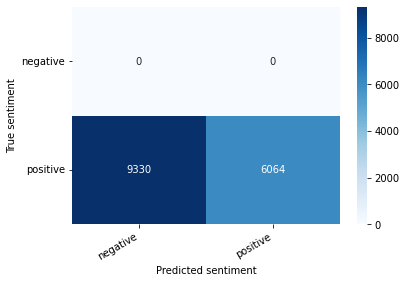

In [7]:
class_names = ['negative','positive']
print("BERT Test Results")
print(classification_report(bert_test_df.bert_pred, bert_test_df.bert_answer, target_names=class_names))
cm_bert = confusion_matrix(bert_test_df.bert_pred, bert_test_df.bert_answer)
df_cm_bert = pd.DataFrame(cm_bert, index=class_names, columns=class_names)
show_confusion_matrix(df_cm_bert)

CNN Test Results
              precision    recall  f1-score   support

    negative       0.76      0.71      0.73      9969
    positive       0.52      0.58      0.55      5425

    accuracy                           0.66     15394
   macro avg       0.64      0.65      0.64     15394
weighted avg       0.67      0.66      0.67     15394



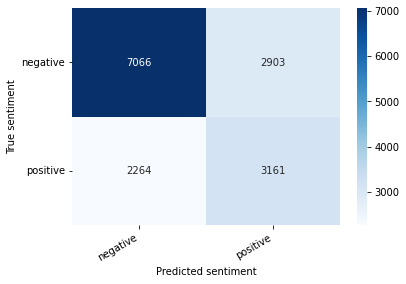

In [8]:
print("CNN Test Results")
print(classification_report(cnn_test_df.cnn_pred, cnn_test_df.cnn_answer, target_names=class_names))
cm_cnn = confusion_matrix(cnn_test_df.cnn_pred, cnn_test_df.cnn_answer)
df_cm_cnn = pd.DataFrame(cm_cnn, index=class_names, columns=class_names)
show_confusion_matrix(df_cm_cnn)

### Ensemble

In [8]:
combined_train_df = pd.concat([bert_train_df[['bert_class_0','bert_class_1','bert_pred','bert_answer']], cnn_train_df[['cnn_class_0','cnn_class_1','cnn_pred','cnn_answer']]], axis = 1)
combined_test_df = pd.concat([bert_test_df[['bert_class_0','bert_class_1','bert_pred','bert_answer']], cnn_test_df[['cnn_class_0','cnn_class_1','cnn_pred','cnn_answer']]], axis = 1)

print(combined_train_df.shape, combined_test_df.shape)

(35517, 8) (15394, 8)


In [9]:
# Use all probabilities from each model as new features for ensemble
X_train = combined_train_df[['bert_class_0','bert_class_1','cnn_class_0','cnn_class_1']]
Y_train = combined_train_df['bert_answer']
X_test = combined_test_df[['bert_class_0','bert_class_1','cnn_class_0','cnn_class_1']]
Y_test = combined_test_df['bert_answer']

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Logistic Regression

In [12]:
logi_model = LogisticRegression(solver = 'lbfgs')
logi_model.fit(X_train_scaled, Y_train)

LogisticRegression()

In [13]:
y_pred = logi_model.predict(X_test_scaled)

In [14]:
print(classification_report(y_pred, Y_test, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.77      0.71      0.74     10108
    positive       0.51      0.59      0.55      5286

    accuracy                           0.67     15394
   macro avg       0.64      0.65      0.64     15394
weighted avg       0.68      0.67      0.67     15394



### SVM

In [15]:
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],'C': [1, 10, 100, 1000]},
               {'kernel': ['linear', 'poly'], 'C': [1, 10, 100, 1000]}]

In [16]:
svm_model = SVC()
svm_model.fit(X_train_scaled, Y_train)

KeyboardInterrupt: 

In [ ]:
Y_pred = svm_model.predict(X_test_scaled)

print(classification_report(y_pred, Y_test, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.77      0.71      0.74     10108
    positive       0.51      0.59      0.55      5286

    accuracy                           0.67     15394
   macro avg       0.64      0.65      0.64     15394
weighted avg       0.68      0.67      0.67     15394



In [ ]:
# Option
# Performing CV to tune parameters for best SVM fit 
svm_model = GridSearchCV(SVC(), params_grid, cv=5)

# View the accuracy score
print('Best score for training data:', svm_model.best_score_,"\n") 

# View the best parameters for the model found using grid search
print('Best C:', svm_model.best_estimator_.C,"\n") 
print('Best Kernel:', svm_model.best_estimator_.kernel,"\n")
print('Best Gamma:', svm_model.best_estimator_.gamma,"\n")

# "final_model"을 사용해서 classification 결과를 확인할 수 있다
final_model = svm_model.best_estimator_